#### **Welcome to Assignment 2**
This assignment consists of three parts. Part-1 is based on the content you learned in Week-3 of course and Part-2 is based on the content you learned in Week-4 of the course. Part-3 is **un-graded** and mainly designed to help you flex the Deep Learning muscles grown in Part-2. 

Unlike the first two parts, you'll have to implement everything from scratch in Part-3. If you find answers to questions in Part-3, feel free to head out to the forums and discuss them with your classmates!

#### **Instructions**
1. Use Python 3.x to run this notebook
2. Write your code only in between the lines 'YOUR CODE STARTS HERE' and 'YOUR CODE ENDS HERE'.
you should not change anything else in the code cells, if you do, the answers you are supposed to get at the end of this assignment might be wrong.
3. Read documentation of each function carefully.
4. All the Best!

# Part-1

In [2]:
# Imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

# %matplotlib inline uncomment this line if you're running this notebook on your local PC

In [3]:
# DO NOT CHANGE THIS CODE
np.random.seed(10)

### Question 1 : Line detection from a given image.


Find the starting and ending point co-ordinates of detected lines of a given image (line.png) using hough transform.

Following criterion need to be satisfied to qualify as a line:

(a) Minimum line length = 60;
(b) Maximum allowed gap between line segments = 250;
(c) Accumulator threshold parameter = 15  (only those lines are returned that get enough votes);
(d) Distance resolution of the accumulator in pixels = 1;
(e) Angle resolution of the accumulator in radians = pi/180



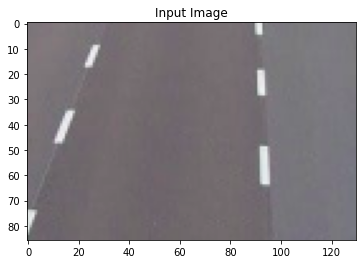

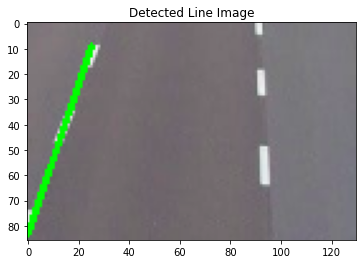

In [4]:
#Read image 
img = cv2.imread('line.png', cv2.IMREAD_COLOR)

# Visualize the input image
plt.imshow(img)
plt.title('Input Image')
plt.show()

#### YOUR CODE STARTS HERE #####
#convert the image to gray-scale
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#### YOUR CODE ENDS HERE #####

#Find the edges in the image using canny detector

edges = cv2.Canny(gray, 50, 200)
#### YOUR CODE STARTS HERE #####

lines = cv2.HoughLinesP(edges,rho=1,theta=np.pi/180,threshold=15,minLineLength=60,maxLineGap=250)

for x1,y1,x2,y2 in lines[0]:
    cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)
    
#### YOUR CODE ENDS HERE #####
plt.imshow(img)
plt.title('Detected Line Image')
plt.show()

##Question 2: Point matching using RANSAC

Given two sets of points related by affine transformation(with an outlier rate), use the RANSAC method to estimate the Affine transformation parameters between them and the number of inliers(Matching points).

What is the estimated number of inliers for an outlier rate of 0.9?


In [1]:
import numpy as np
np.random.seed(0)


# Affine Transformation
# |x'|  = |a, b| * |x|  +  |tx|
# |y'|    |c, d|   |y|     |ty|
# points_t =    A   * points_s  + t

# -------------------------------------------------------------

class Transform():

    def create_case(self, out_rate):
        ''' CREATE_CASE

            Method to generate a test case for affine transformation

            Input arguments:
            - out_rate : the percentage of outliers in test case

            Outputs:
            - points_s : Source points that will be transformed
            - points_t : warped points
            - A, t : parameters of affine transformation, A is a 2x2
            matrix, t is a 2x1 vector, both of them are created randomly

        '''


        # Generate an affine transformation
        # A is a 2x2 matrix, with values in range -2 to 2
        A = 4 * np.random.rand(2, 2) - 2

        # t is a 2x1 vector, with values in range -10 to 10
        t = 20 * np.random.rand(2, 1) - 10

        # Set the num_points = 1000 for the test case
        num_points = 1000

        #### YOUR CODE STARTS HERE ####
        # Compute the no. of outliers and the no. of inliers respectively
        outliers = int(out_rate*num_points)
        inliers = num_points - outliers
        #### YOUR CODE ENDS HERE ####

        # Gernerate source points, with scope from (0,0) to (100, 100)
        points_s = 100 * np.random.rand(2, num_points)

        # Initialization of the warped points matrix
        points_t = np.zeros((2, num_points))

        #### YOUR CODE STARTS HERE ####
        # Compute inliers in warped points matrix by applying A and t
        points_t[:, :inliers] = np.matmul(A,points_s[:,:inliers])+t
        #### YOUR CODE ENDS HERE ####

        # Outliers in warped points matrix
        points_t[:, inliers:] = 100 * np.random.rand(2, outliers)

        # Reset the order of warped points matrix
        # outliers and inliers will scatter randomly in test case
        rand_inx = np.random.permutation(num_points)
        points_s = points_s[:, rand_inx]
        points_t = points_t[:, rand_inx]

        return A, t, points_s, points_t

    def affine_transformation(self, points_s, points_t):  
        ''' AFFINE_TRANSFORMATION

            Perform affine transformation

            Input arguments:
            - points_t : points in target image
            - points_s : points in source image

            Outputs:

            - A, t : the affine transformation, A is a 2x2 matrix
            that indicates the rotation and scaling transformation,
            t is a 2x1 vector determines the translation

            Method:

            To estimate an affine transformation between two images,
            at least 3 corresponding points are needed.
            In this case, 6-parameter affine transformation are taken into
            consideration, which is shown as follows:

            | x' | = | a b | * | x | + | tx |
            | y' |   | c d |   | y |   | ty |

            For 3 corresponding points, 6 equations can be formed as below:

            | x1 y1 0  0  1 0 |       | a  |       | x1' |
            | 0  0  x1 y1 0 1 |       | b  |       | y1' |
            | x2 y2 0  0  1 0 |   *   | c  |   =   | x2' |
            | 0  0  x2 y2 0 1 |       | d  |       | y2' |
            | x3 y3 0  0  1 0 |       | tx |       | x3' |
            | 0  0  x3 y3 0 1 |       | ty |       | y3' |

            |------> M <------|   |-> theta <-|   |-> b <-|

            Solve the equation by calculating:  theta = M \ b
            Thus, affine transformation can be obtained as:

            A = | a b |     t = | tx |
                | c d |         | ty |

        '''

        #### YOUR CODE STARTS HERE ####
        
        M = np.zeros((6,6))
        B = np.zeros((6,1))
        M[0][0],M[0][1],M[0][4] = points_s[0][0],points_s[1][0],1
        M[1][2],M[1][3],M[1][5] = points_s[0][0],points_s[1][0],1
        
        M[2][0],M[2][1],M[2][4] = points_s[0][1],points_s[1][1],1
        M[3][2],M[3][3],M[3][5] = points_s[0][1],points_s[1][1],1
        
        M[4][0],M[4][1],M[4][4] = points_s[0][2],points_s[1][2],1
        M[5][2],M[5][3],M[5][5] = points_s[0][2],points_s[1][2],1
        
        #print(M)
        
        for i in range(points_t.shape[1]):
            B[2*i]=points_t[0][i]
            B[2*i+1]=points_t[1][i]
        
        #print(points_t,B)
        
        theta = np.matmul((np.linalg.inv(M)),B)
        ret_A = np.zeros((2,2))
        ret_t = np.zeros((2,1))
        ret_A[0][0],ret_A[0][1],ret_A[1][0],ret_A[1][1] = theta[0],theta[1],theta[2],theta[3]
        ret_t[0][0],ret_t[1][0] = theta[4],theta[5]
        return ret_A,ret_t

        #### YOUR CODE ENDS HERE ####
# -------------------------------------------------------------

# Create instance
tf = Transform()

# Generate a test case as validation with
# a rate of outliers
out_rate = 0.90
A_true, t_true, points_s, points_t = tf.create_case(out_rate)

# At least 3 corresponding points to
# estimate affine transformation
L = 3
# Randomly select 3 pairs of points to do estimation
idx = np.random.randint(0, points_s.shape[1], (L, 1))

A_test, t_test = tf.affine_transformation(points_s[:, idx], points_t[:, idx])

# -------------------------------------------------------------
# Test Class RansacClass
# The number of iterations in RANSAC
ITER_NUM = 2000


class RansacClass():

    def __init__(self, L=3, thr=1): 
        ''' __INIT__

            Initialize the instance.

            Input arguments:

            - L : the number of corresponding points,
            default is 3
            - thr : threshold that determines which points are inliers
            by comparing residual with it

        '''

        self.L = L
        self.thr = thr

    def calculate_distance(self, A, t, points_s, points_t):     
        ''' CALCULATE_DISTANCE

            Compute residual length between estimation and 
            real target points.
 

            Input arguments:

            - A, t : the estimated affine transformation
                     (using least square)
            - points_s : key points taken from source image
            - points_t : key points taken from target image

            Output:

            - residual : Euclidean distance between target 
            points and estimated points. Euclidean distance is
            nothing but the residual length

        '''

        ###YOUR CODE START HERE

        residual = 0
        for i in range(points_s.shape[1]):
            p1 = np.zeros((2,1))
            p2 = np.zeros((2,1))

            p1[0],p1[1] = points_s[0][i],points_s[1][i]
            p1 = np.dot(A,p1)+t
            p2[0],p2[1] = points_t[0][i],points_t[1][i]
            residual = residual + np.linalg.norm(p1-p2)
        return residual

        ###YOUR CODE ENDS HERE

    def apply_ransac(self, points_s, points_t):
        ''' APPLY_RANSAC

            Use this method to get the estimateda ffine 
            transformation, also inliers.

            Input arguments:

            - points_s : key points from source image
            - points_t : key points from target image

            Output:

            - A, t : estimated affine transformation
            - inliers : indices of inliers 

        '''
        #### YOUR CODE START HERE
        inlier_cnt = 0
        calc_A = np.zeros((2,2))
        calc_t = np.zeros((2,1))
        for i in range(ITER_NUM):
            idx = []
            maxlimit = points_s.shape[1]-self.L
            lowlimit = 0
            for j in range(self.L):
                idx.append( np.random.randint(lowlimit, maxlimit))
                lowlimit = idx[j]+1
                maxlimit = maxlimit+1
            A_1, t_1 = tf.affine_transformation(points_s[:, idx], points_t[:, idx])
            #print(np.matmul(A_1,points_s[:,:3])+t_1)
            #print(points_t[:,:3])
            cnt=0
            for j in range(points_s.shape[1]):
                p1 = np.zeros((2,1))
                p2 = np.zeros((2,1))
                
                p1[0],p1[1] = points_s[0][j],points_s[1][j]
                p1 = np.dot(A_1,p1)+t_1
                
                p2[0],p2[1] = points_t[0][j],points_t[1][j]
                
                dist = np.linalg.norm(p1-p2)
                if dist <= self.thr:
                    cnt+=1      
            if inlier_cnt < cnt:
                inlier_cnt = cnt
                calc_A = A_1
                calc_t = t_1
                
                
                
        estimated = np.dot(calc_A,points_s)+calc_t
        temp = estimated - points_t
        inlier_x = []
        inlier_y = []
        for i in range(temp.shape[1]):
            dist = np.sqrt(temp[0][i]**2+temp[1][i]**2)
            if dist <= self.thr:
                inlier_x.append(points_s[0][i])
                inlier_y.append(points_s[1][i])
                
        inliers = np.zeros((2,len(inlier_x)))
        for i in range(len(inlier_x)):
            inliers[0][i]=inlier_x[i]
            inliers[1][i]=inlier_y[i]
            
        return calc_A,calc_t,inliers
        #### YOUR CODE ENDS HERE
# -------------------------------------------------------------

# Create instance
rs = RansacClass(L=3, thr=1)

residual = rs.calculate_distance(A_test, t_test, points_s, points_t)
A_rsc, t_rsc, inliers = rs.apply_ransac(points_s, points_t)

# print the number of inliners or point matches
print(inliers[0].shape)


(101,)


### Question 3: Detect corners in a given image using Harris Corner Detection Algorithm

Find the number of detected corner points in a given image (line.png) using Harris Corner Detection Algorithm. Note that, Following criterion MUST be satisfied while applying Harris Corner detection Algorithm:

(a)  The size of neighbourhood considered for corner detection = 2.
(b)  Aperture parameter of Sobel derivative used = 3.
(c)  Harris detector free parameter in the equation = 0.04.

How many corners are detected?



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

%matplotlib inline

# Read in the image
image = cv2.imread('line.png')

# Make a copy of the image
image_copy = np.copy(image)

# Change color to RGB (from BGR)
image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

###YOUR CODE STARTS HERE

## STEP 1:  Convert to grayscale 
gray = cv2.cvtColor(image_copy,cv2.COLOR_RGB2GRAY)

## STEP 2: Detect corners 
dest = cv2.cornerHarris(gray,2,3,0.04)

## STEP 3: Dilate corner image to enhance corner points
dest = cv2.dilate(dest,None)

## STEP 4:set threshold value as 0.1 * (maximum value of dilated corner image obtained from STEP3)
thresh = 0.1*dest.max()
image_copy[dest>thresh]=[0,0,255]

## STEP 5: Count numer of detected corner points and draw them on the image
count = 0
for i in range (dest.shape[0]):
    for j in range (dest.shape[1]):
        if dest[i][j] > thresh:
            count=count+1
cv2.imshow('Image with Corners', image_copy) 
print(count) 
if cv2.waitKey(0) & 0xff == 27: 
    cv2.destroyAllWindows() 
### YOUR CODE ENDS HERE

222


# Part-2

In this section, we will train a neural network to learn to identify numerals from [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Fill out the missing pieces in each of the following cells. 

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torch.nn.functional as F
import timeit
import unittest

## Please DONOT remove these lines. 
torch.manual_seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)

### Data Loading and Pre-processing

In [2]:
# check availability of GPU and set the device accordingly
#### YOUR CODE STARTS HERE ####
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define a transforms for preparing the dataset
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
         # convert the image to a pytorch tensor
        # normalise the images with mean (0.1307) and std (0.3081) of the dataset
#### YOUR CODE ENDS HERE ####

/home/shivashish/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370172916/work/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
# Load the MNIST training, test datasets using `torchvision.datasets.MNIST` using the transform defined above
#### YOUR CODE STARTS HERE ####
train_dataset =  datasets.MNIST('files', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('files', train=False, download=True, transform=transform)
#### YOUR CODE ENDS HERE ####

In [4]:
# create dataloaders for training and test datasets
# use a batch size of 32 and set shuffle=True for the training set
#### YOUR CODE STARTS HERE ####
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
#### YOUR CODE ENDS HERE ####

### Network Definition

In [48]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #### YOUR CODE STARTS HERE ####
        # define a conv layer with output channels as 16, kernel size of 3 and stride of 1
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1)
        
        #torch.nn.init.xavier_normal_(self.conv1.weight)
        #torch.nn.init.zeros_(self.conv1.bias)
        
        #self.conv1.weight.data.fill_(1)
        #self.conv1.bias.data.fill_(1)
        
        # define a conv layer with output channels as 32, kernel size of 3 and stride of 1
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1)
        
        #torch.nn.init.xavier_normal_(self.conv2.weight)
        #torch.nn.init.zeros_(self.conv2.bias)
        
        #self.conv2.weight.data.fill_(1)
        #self.conv2.bias.data.fill_(1)
        
        # define a conv layer with output channels as 64, kernel size of 3 and stride of 1
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1)
        
        #torch.nn.init.xavier_normal_(self.conv3.weight)
        #torch.nn.init.zeros_(self.conv3.bias)
        
        #self.conv3.weight.data.fill_(1)
        #self.conv3.bias.data.fill_(1)
        
        # define a max pooling layer with kernel size 2
        self.pool = nn.MaxPool2d(2,2)
        
        # define dropout layer with a probability of 0.25
        self.drop1 = nn.Dropout2d(0.25)
        
        # define dropout layer with a probability of 0.5
        self.drop2 = nn.Dropout2d(0.5)
        
        # define a linear(dense) layer with 128 output features
        self.fc1 = nn.Linear(64*11*11, 128) 
        
        # define a linear(dense) layer with output features corresponding to the number of classes in the dataset
        self.fc2 = nn.Linear(128, len(train_dataset.classes))
        
        #self.bn1 = nn.BatchNorm2d(16)
        #self.bn2 = nn.BatchNorm2d(32)
        #self.bn3 = nn.BatchNorm2d(64)
        #### YOUR CODE ENDS HERE ####

    def forward(self, x):
        # Use the layers defined above in a sequential way (folow the same as the layer definitions above) and 
        # write the forward pass, after each of conv1, conv2, conv3 and fc1 use a relu activation. 
        # use the first dropout after maxpool and the other one before you final FC layer
        #### YOUR CODE STARTS HERE ####
        out = self.conv1(x)
        #out = self.bn1(out)
        out = F.relu(out)
        #out = torch.sigmoid(out)
        
        out = self.conv2(out)
        #out = self.bn2(out)
        out = F.relu(out)
        #out = torch.sigmoid(out)
        
        out = self.conv3(out)
        #out = self.bn3(out)
        out = F.relu(out)
        #out = torch.sigmoid(out)
        
        out = self.pool(out)
        out = self.drop1(out)
        
        out = out.view(-1, 64 * 11 * 11)
        out = self.fc1(out)
        out = F.relu(out)
        #out = torch.sigmoid(out)
        
        out = self.drop2(out)
        out = self.fc2(out)
        #### YOUR CODE ENDS HERE ####
        output = F.log_softmax(out, dim=1)
        return output

### Sanity Check
Make sure all the tests below pass without any errors, before you proceed with the training part.

In [49]:
import unittest

class TestImplementations(unittest.TestCase):
    
    # Dataloading tests
    def test_dataset(self):
        self.dataset_classes = ['0 - zero',
                                '1 - one',
                                '2 - two',
                                '3 - three',
                                '4 - four',
                                '5 - five',
                                '6 - six',
                                '7 - seven',
                                '8 - eight',
                                '9 - nine']
        self.assertTrue(train_dataset.classes == self.dataset_classes)
        self.assertTrue(train_dataset.train == True)
    
    def test_dataloader(self):        
        self.assertTrue(train_dataloader.batch_size == 32)
        self.assertTrue(test_dataloader.batch_size == 32)      
         
    def test_total_parameters(self):
        model = Net().to(device)
        self.assertTrue(sum(p.numel() for p in model.parameters()) == 1015946)

suite = unittest.TestLoader().loadTestsFromModule(TestImplementations())
unittest.TextTestRunner().run(suite)

...
----------------------------------------------------------------------
Ran 3 tests in 0.007s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

### Training and Inference

In [50]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
      #### YOUR CODE STARTS HERE ####
        # send the image, target to the device
        data, target = data.to(device), target.to(device)
        
        # flush out the gradients stored in optimizer
        optimizer.zero_grad()

        # pass the image to the model and assign the output to variable named output
        output = model(data)
        
        # calculate the loss (use nll_loss in pytorch)
        criterion = nn.NLLLoss()
        loss = criterion(output,target)
        
        # do a backward pass
        loss.backward()
        
        # update the weights
        optimizer.step()
        
      #### YOUR CODE ENDS HERE ####
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [51]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
          ### YOUR CODE STARTS HERE ####
            # send the image, target to the device
            data, target = data.to(device), target.to(device)
            # pass the image to the model and assign the output to variable named output
            output = model(data)
            _, pred = torch.max(output.data, 1)
            criterion = nn.NLLLoss()
            loss = criterion(output,target)
            test_loss += loss# sum up batch loss
          #### YOUR CODE ENDS HERE ####
            # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

### Question 4

Use Adam as the optimiser and train the model for 25 epochs. Report the train, test loss and accuracies along with the total time taken for training. (Use plots if required)

In [52]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.Adam(model.parameters()), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)

"""
Train Epoch: 25 [59520/60000 (99%)]	Loss: 0.216810

It took 44.95794415473938 seconds

Test set: Average loss: 0.0015, Accuracy: 9839/10000 (98%)
"""

Train Epoch: 25 [0/60000 (0%)]	Loss: 2.295593
Train Epoch: 25 [640/60000 (1%)]	Loss: 1.034042
Train Epoch: 25 [1280/60000 (2%)]	Loss: 0.846576
Train Epoch: 25 [1920/60000 (3%)]	Loss: 0.682577
Train Epoch: 25 [2560/60000 (4%)]	Loss: 0.480521
Train Epoch: 25 [3200/60000 (5%)]	Loss: 0.552732
Train Epoch: 25 [3840/60000 (6%)]	Loss: 0.312827
Train Epoch: 25 [4480/60000 (7%)]	Loss: 0.352883
Train Epoch: 25 [5120/60000 (9%)]	Loss: 0.258511
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.258494
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.263231
Train Epoch: 25 [7040/60000 (12%)]	Loss: 0.375897
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.107800
Train Epoch: 25 [8320/60000 (14%)]	Loss: 0.136959
Train Epoch: 25 [8960/60000 (15%)]	Loss: 0.125709
Train Epoch: 25 [9600/60000 (16%)]	Loss: 0.282815
Train Epoch: 25 [10240/60000 (17%)]	Loss: 0.045503
Train Epoch: 25 [10880/60000 (18%)]	Loss: 0.242224
Train Epoch: 25 [11520/60000 (19%)]	Loss: 0.461388
Train Epoch: 25 [12160/60000 (20%)]	Loss: 0.252175
Train Epo

'\nTrain Epoch: 25 [59520/60000 (99%)]\tLoss: 0.304866\n\nIt took 51.330891370773315 seconds for 25 epochs.\n\nTest set: Average loss: 0.0014, Accuracy: 9848/10000 (98%)\n'

### Question 5

Modify the network defined in the previous step to replace ReLU activations with Sigmoid and report the final test accuracy. Is there a drop in accuracy, what do you think is the reason? 

In [9]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.Adam(model.parameters()), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)
"""
Train Epoch: 25 [59520/60000 (99%)]	Loss: 2.290709
51.419480085372925 seconds

Test set: Average loss: 0.0723, Accuracy: 974/10000 (10%)
"""

# We observe that accuracy is very low 10% as compared to RELU which was 98% because
# sigmoid is only useful for binary classification where we have two classes
# but in our case we have 10 classes one for each digit and hence RELU performs much better

Train Epoch: 25 [0/60000 (0%)]	Loss: 2.323973
Train Epoch: 25 [640/60000 (1%)]	Loss: 2.363800
Train Epoch: 25 [1280/60000 (2%)]	Loss: 2.319752
Train Epoch: 25 [1920/60000 (3%)]	Loss: 2.497897
Train Epoch: 25 [2560/60000 (4%)]	Loss: 2.341678
Train Epoch: 25 [3200/60000 (5%)]	Loss: 2.361397
Train Epoch: 25 [3840/60000 (6%)]	Loss: 2.329359
Train Epoch: 25 [4480/60000 (7%)]	Loss: 2.307093
Train Epoch: 25 [5120/60000 (9%)]	Loss: 2.376746
Train Epoch: 25 [5760/60000 (10%)]	Loss: 2.376432
Train Epoch: 25 [6400/60000 (11%)]	Loss: 2.318800
Train Epoch: 25 [7040/60000 (12%)]	Loss: 2.397024
Train Epoch: 25 [7680/60000 (13%)]	Loss: 2.258260
Train Epoch: 25 [8320/60000 (14%)]	Loss: 2.410280
Train Epoch: 25 [8960/60000 (15%)]	Loss: 2.349347
Train Epoch: 25 [9600/60000 (16%)]	Loss: 2.357315
Train Epoch: 25 [10240/60000 (17%)]	Loss: 2.441663
Train Epoch: 25 [10880/60000 (18%)]	Loss: 2.268611
Train Epoch: 25 [11520/60000 (19%)]	Loss: 2.368104
Train Epoch: 25 [12160/60000 (20%)]	Loss: 2.308902
Train Epo

### Question 6

Train the network defined in Question-1 with a different optimiser other than Adam, do you see any difference in performance? Substantiate your observations with relevant explanations.

In [11]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.SGD(model.parameters(), lr=0.001), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)

"""
Train Epoch: 25 [59520/60000 (99%)]	Loss: 0.280682
It took 36.430084466934204 seconds

Test set: Average loss: 0.0106, Accuracy: 9037/10000 (90%)
"""

# We observe that Adam performs much better as comapred to SGD as SGD is slower and requires more epochs
# and hence Adam performs better

Train Epoch: 25 [0/60000 (0%)]	Loss: 2.319507
Train Epoch: 25 [640/60000 (1%)]	Loss: 2.282302
Train Epoch: 25 [1280/60000 (2%)]	Loss: 2.302454
Train Epoch: 25 [1920/60000 (3%)]	Loss: 2.298838
Train Epoch: 25 [2560/60000 (4%)]	Loss: 2.294550
Train Epoch: 25 [3200/60000 (5%)]	Loss: 2.279983
Train Epoch: 25 [3840/60000 (6%)]	Loss: 2.283893
Train Epoch: 25 [4480/60000 (7%)]	Loss: 2.270157
Train Epoch: 25 [5120/60000 (9%)]	Loss: 2.279892
Train Epoch: 25 [5760/60000 (10%)]	Loss: 2.289243
Train Epoch: 25 [6400/60000 (11%)]	Loss: 2.268290
Train Epoch: 25 [7040/60000 (12%)]	Loss: 2.269900
Train Epoch: 25 [7680/60000 (13%)]	Loss: 2.264458
Train Epoch: 25 [8320/60000 (14%)]	Loss: 2.270468
Train Epoch: 25 [8960/60000 (15%)]	Loss: 2.248198
Train Epoch: 25 [9600/60000 (16%)]	Loss: 2.264637
Train Epoch: 25 [10240/60000 (17%)]	Loss: 2.264180
Train Epoch: 25 [10880/60000 (18%)]	Loss: 2.220991
Train Epoch: 25 [11520/60000 (19%)]	Loss: 2.228087
Train Epoch: 25 [12160/60000 (20%)]	Loss: 2.227762
Train Epo

'\nTrain Epoch: 25 [59520/60000 (99%)]\tLoss: 0.018934\nIt took 39.449726819992065 seconds\n\nTest set: Average loss: 0.0016, Accuracy: 9837/10000 (98%)\n'

### Question 7

Initialize the `Conv2d` layers in the network defined in Question-1 `(Net)` with all ones (both weights and bias). Train the network with Adam optimizer and report the final test accuracy. Is there any difference in the performance? If yes, what do you think is the reason? 

In [32]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.Adam(model.parameters()), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)

"""
Train Epoch: 25 [59520/60000 (99%)]	Loss: 2.310387
It took 50.04670596122742 seconds

Test set: Average loss: 0.0713, Accuracy: 1239/10000 (12%)"""

# We observe that it performs very poor as accuracy decrease from 98 to 12 because all the weights are
# initialised with same value and gradient also becomes similar and hence weight updates are also similar
# and neural network fails to learn 

Train Epoch: 25 [0/60000 (0%)]	Loss: 274924.687500
Train Epoch: 25 [640/60000 (1%)]	Loss: 1006.809570
Train Epoch: 25 [1280/60000 (2%)]	Loss: 2.296385
Train Epoch: 25 [1920/60000 (3%)]	Loss: 2.308664
Train Epoch: 25 [2560/60000 (4%)]	Loss: 2.293013
Train Epoch: 25 [3200/60000 (5%)]	Loss: 2.306288
Train Epoch: 25 [3840/60000 (6%)]	Loss: 716.669373
Train Epoch: 25 [4480/60000 (7%)]	Loss: 2.242922
Train Epoch: 25 [5120/60000 (9%)]	Loss: 2.300879
Train Epoch: 25 [5760/60000 (10%)]	Loss: 2.290262
Train Epoch: 25 [6400/60000 (11%)]	Loss: 2.299521
Train Epoch: 25 [7040/60000 (12%)]	Loss: 2.232559
Train Epoch: 25 [7680/60000 (13%)]	Loss: 2.238302
Train Epoch: 25 [8320/60000 (14%)]	Loss: 2.231706
Train Epoch: 25 [8960/60000 (15%)]	Loss: 2.301502
Train Epoch: 25 [9600/60000 (16%)]	Loss: 2.304616
Train Epoch: 25 [10240/60000 (17%)]	Loss: 2.294814
Train Epoch: 25 [10880/60000 (18%)]	Loss: 2.233745
Train Epoch: 25 [11520/60000 (19%)]	Loss: 2.305026
Train Epoch: 25 [12160/60000 (20%)]	Loss: 2.287498

### Question 8

Initialize the network defined in Question-1 `(Net)` with Xavier's initialization ([torch.nn.init.xavier_normal](https://pytorch.org/docs/stable/nn.init.html))(for bias use zero). Train the network with Adam optimizer and report the final test accuracy.

In [47]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.Adam(model.parameters()), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)

"""
Train Epoch: 25 [59520/60000 (99%)]	Loss: 0.239904
It took 63.539113998413086 seconds

Test set: Average loss: 0.0013, Accuracy: 9866/10000 (99%)"""

# We observe that we get the best accuracy of 99 percent using xavier's initialisation

Train Epoch: 25 [0/60000 (0%)]	Loss: 2.299160
Train Epoch: 25 [640/60000 (1%)]	Loss: 1.359211
Train Epoch: 25 [1280/60000 (2%)]	Loss: 0.725579
Train Epoch: 25 [1920/60000 (3%)]	Loss: 0.894380
Train Epoch: 25 [2560/60000 (4%)]	Loss: 0.740585
Train Epoch: 25 [3200/60000 (5%)]	Loss: 0.203165
Train Epoch: 25 [3840/60000 (6%)]	Loss: 0.265607
Train Epoch: 25 [4480/60000 (7%)]	Loss: 0.210773
Train Epoch: 25 [5120/60000 (9%)]	Loss: 0.339454
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.071046
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.234347
Train Epoch: 25 [7040/60000 (12%)]	Loss: 0.437477
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.260844
Train Epoch: 25 [8320/60000 (14%)]	Loss: 0.467737
Train Epoch: 25 [8960/60000 (15%)]	Loss: 0.106160
Train Epoch: 25 [9600/60000 (16%)]	Loss: 0.117235
Train Epoch: 25 [10240/60000 (17%)]	Loss: 0.225432
Train Epoch: 25 [10880/60000 (18%)]	Loss: 0.309695
Train Epoch: 25 [11520/60000 (19%)]	Loss: 0.317718
Train Epoch: 25 [12160/60000 (20%)]	Loss: 0.305162
Train Epo

### Question 9

Add three batch-norm layers to the network defined in `Question-1` and report the final test accuracy. How does batch-norm help? 

In [25]:
import time

model = Net()

t0 = time.time()
train(model = model, device=device, train_loader=train_dataloader, optimizer = optim.Adam(model.parameters()), epoch=25)
print('{} seconds'.format(time.time() - t0))
test(model = model, device=device, test_loader=test_dataloader)

"""Train Epoch: 25 [59520/60000 (99%)]	Loss: 0.114644
It took 61.01683473587036 seconds

Test set: Average loss: 0.0016, Accuracy: 9842/10000 (98%)"""

# It performs almost similar to without batch-normalisation

Train Epoch: 25 [0/60000 (0%)]	Loss: 2.473517
Train Epoch: 25 [640/60000 (1%)]	Loss: 1.451150
Train Epoch: 25 [1280/60000 (2%)]	Loss: 0.557861
Train Epoch: 25 [1920/60000 (3%)]	Loss: 0.545373
Train Epoch: 25 [2560/60000 (4%)]	Loss: 0.518884
Train Epoch: 25 [3200/60000 (5%)]	Loss: 0.425732
Train Epoch: 25 [3840/60000 (6%)]	Loss: 0.599937
Train Epoch: 25 [4480/60000 (7%)]	Loss: 0.292830
Train Epoch: 25 [5120/60000 (9%)]	Loss: 0.176513
Train Epoch: 25 [5760/60000 (10%)]	Loss: 0.421338
Train Epoch: 25 [6400/60000 (11%)]	Loss: 0.255570
Train Epoch: 25 [7040/60000 (12%)]	Loss: 0.276929
Train Epoch: 25 [7680/60000 (13%)]	Loss: 0.353199
Train Epoch: 25 [8320/60000 (14%)]	Loss: 0.123115
Train Epoch: 25 [8960/60000 (15%)]	Loss: 0.251170
Train Epoch: 25 [9600/60000 (16%)]	Loss: 0.155798
Train Epoch: 25 [10240/60000 (17%)]	Loss: 0.055611
Train Epoch: 25 [10880/60000 (18%)]	Loss: 0.293593
Train Epoch: 25 [11520/60000 (19%)]	Loss: 0.119252
Train Epoch: 25 [12160/60000 (20%)]	Loss: 0.126260
Train Epo

'Train Epoch: 25 [59520/60000 (99%)]\tLoss: 0.081537\nIt took 51.798359632492065 seconds\n\nTest set: Average loss: 0.0020, Accuracy: 9823/10000 (98%)'

# Part-3 (Optional)

This section is un-graded and purely for practice. 

Main focus of this part is to help you flex the deep learning muscles built in the above part. You should build a network on the [SVHN dataset](http://ufldl.stanford.edu/housenumbers/). This dataset is similar to MNIST but unlike MNIST, the images are colored and more complex. 

As of writing this, the state-of-the-art(SoTA) performance on this dataset is 98.98%. You can try to start with the simple network we defined above for the MNSIT dataset(with some modification for dealing with different sized colored images unlike MNIST). But to achive the SoTA performance you need to do a lot of hackery. These are list of few things, we would encourage you to try: 

- Use data augmentation wisely. Read and understand how to perform the augmentations listed below. 
    * RandomFlips, Color Jittering
    * Cutout, Cutmix
    * Mixup
    * Auto-augment

- Try to increase the image size using standard image interpolation techniques. Try using tricks like Progressive resizing of images and see if it helps. 

- After certain number of layers, adding more layer might not be of much help, run experiments on SVHN and see if you observe this. 

- To understand the difficulties in training deeper networks read this paper: [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)

- To improve the performance on SVHN, try using architectures like [ResNet](https://arxiv.org/abs/1512.03385), [DesnseNet](https://arxiv.org/abs/1608.06993) or [EfficientNet](https://arxiv.org/abs/1905.11946). Most of these architectures are available by default in PyTorch.
